In [1]:
import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import custom_layers
from PATH_G import PATH_FINAL
from sklearn.metrics import confusion_matrix

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
MODEL_PATH = 'MODEL_INCEPTIONV3'
LR = 0.000025
batch_size = 32
img_height = 299
img_width = 299

In [3]:
# load pre-trained (imagenet) DenseNet model : 121 which has [6,12,24,16] layers in the 4 dense blocks
DenseNet121 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape =(img_height, img_width, 3))

In [4]:
# tf.keras.utils.plot_model(DenseNet121, to_file='DenseNet121.png', show_shapes=True, show_layer_names=True)

In [5]:
study_dir = pathlib.Path(PATH_FINAL)

train_ds = tf.keras.utils.image_dataset_from_directory(
    study_dir,
    validation_split=0.1,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    study_dir,
    validation_split=0.1,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

labels = train_ds.class_names
print(labels)



Found 3808 files belonging to 7 classes.
Using 3428 files for training.
Found 3808 files belonging to 7 classes.
Using 380 files for validation.
['angle', 'greater_curvature', 'junction', 'oesophagus', 'pylore_antre', 'retro_vision', 'unqualified']


In [6]:
# the dataset is unbalanced, i'll use class weights for training
p = 3808/7 
c_w = [p/447, p/461, p/580, p/444, p/736, p/640, p/500]
class_weights = {count:value for count, value in enumerate(c_w)}
print(class_weights)

{0: 1.2170022371364653, 1: 1.1800433839479392, 2: 0.9379310344827586, 3: 1.2252252252252251, 4: 0.7391304347826086, 5: 0.85, 6: 1.088}


In [7]:
#for images, labels in train_ds.take(1):
#    for i in range(9):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(int(labels[i]))
#        plt.axis("off")


In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
    custom_layers.Random90Rotation(),
    #custom_layers.RandomHue(),
    #custom_layers.RandomGaussian()
])

In [9]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(img_height, img_width),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset = -1)
])

In [10]:
dense_end = tf.keras.Sequential([
    # https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024,activation="relu"),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dropout(0.5)
])

prediction_layer = tf.keras.layers.Dense(len(labels),activation='softmax')

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = resize_and_rescale(x)
x = DenseNet121(x)
x = dense_end(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

# initially freeze DenseNet to avoid overfitting, will unfreeze during fine-tuning 
#for layer in model.layers[:-2]:
#    layer.trainable=False 
    
#for layer in model.layers[-2:]:
#    layer.trainable=True

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
sequential_2 (Sequential)    (None, 512)               2631168   
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 3591      
Total params: 24,437,543
Trainable params: 24,399,015
Non-trainable params: 38,528
____________________________________________

(-0.5, 298.5, 298.5, -0.5)

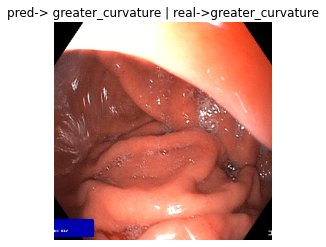

In [13]:
### TEST UNTRAINED MODEL ###
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_ds))
pred = model.predict(image_batch)

source = image_batch[0].numpy()/255
index_pred = np.argmax(pred[0])
index_real = label_batch[0]

plt.imshow(source)
plt.title("pred-> " + labels[index_pred]+" | real->" + labels[index_real])
plt.axis("off")

In [14]:
# Defines fit callbacks
checkpoint =  tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_loss', save_best_only=True)
early =  tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8)
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                              patience=2, min_lr=LR/20)
fit_callbacks = [checkpoint,early,plateau]

In [15]:
history_start = model.fit(
    train_ds,
    epochs= 5,
    validation_data=val_ds,
    callbacks=fit_callbacks,
    class_weight = class_weights
)
model.evaluate(train_ds)

for layer in model.layers[:-2]:
    layer.trainable=True

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    metrics=['accuracy']
)
model.evaluate(train_ds)
history_fine_tuning = model.fit(
    train_ds,
    epochs= 5,
    validation_data=val_ds,
    callbacks=fit_callbacks,
    class_weight = class_weights
)
model.evaluate(train_ds)

Epoch 1/8
108/108 [==============================] - 104s 784ms/step - loss: 1.9040 - accuracy: 0.3626 - val_loss: 1.2407 - val_accuracy: 0.7289
Epoch 2/8
108/108 [==============================] - 73s 676ms/step - loss: 0.8098 - accuracy: 0.7197 - val_loss: 0.6165 - val_accuracy: 0.8211
Epoch 3/8
108/108 [==============================] - 73s 678ms/step - loss: 0.4895 - accuracy: 0.8340 - val_loss: 0.4184 - val_accuracy: 0.8763
Epoch 4/8
108/108 [==============================] - 73s 678ms/step - loss: 0.3378 - accuracy: 0.8906 - val_loss: 0.3933 - val_accuracy: 0.8789
Epoch 5/8
108/108 [==============================] - 73s 679ms/step - loss: 0.2560 - accuracy: 0.9157 - val_loss: 0.3556 - val_accuracy: 0.8921
Epoch 6/8
108/108 [==============================] - 73s 677ms/step - loss: 0.1916 - accuracy: 0.9326 - val_loss: 0.3658 - val_accuracy: 0.9026
Epoch 7/8
108/108 [==============================] - 73s 678ms/step - loss: 0.1344 - accuracy: 0.9548 - val_loss: 0.3932 - val_accuracy

[0.015049167908728123, 0.9941657185554504]

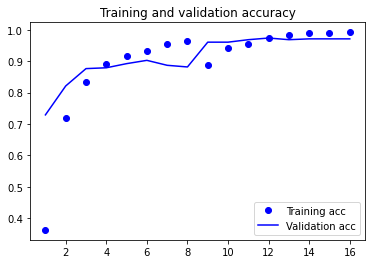

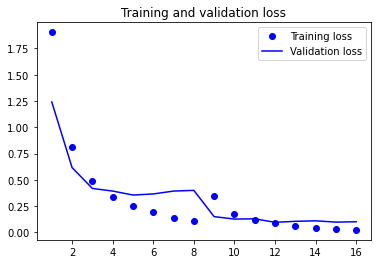

In [16]:
### Training Plots ###
acc = history_start.history['accuracy']
val_acc = history_start.history['val_accuracy']
loss = history_start.history['loss']
val_loss = history_start.history['val_loss']

acc = np.hstack([acc,history_fine_tuning.history['accuracy']])
val_acc = np.hstack([val_acc,history_fine_tuning.history['val_accuracy']])
loss = np.hstack([loss,history_fine_tuning.history['loss']])
val_loss = np.hstack([val_loss,history_fine_tuning.history['val_loss']])


epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

12/12 [==============================] - 2s 182ms/step - loss: 0.1014 - accuracy: 0.9711


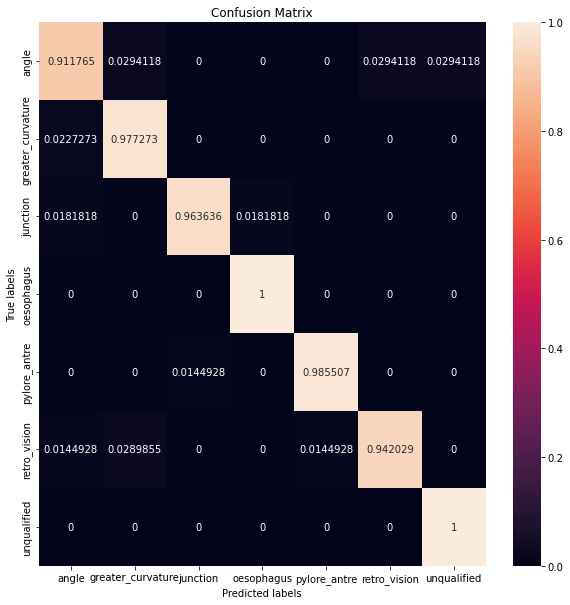

In [17]:
### model evaluation ###
#model = tf.keras.models.load_model(MODEL_PATH)
model.evaluate(val_ds)
#model.save(MODEL_PATH)

validation_iterator = iter(val_ds)
pred_label = np.array([])
true_label = np.array([])
while True:
    image_batch, label_batch = validation_iterator.get_next()
    pred_label = np.append(pred_label,model.predict(image_batch).argmax(1))
    true_label = np.append(true_label,label_batch)
    if len(image_batch) != batch_size : 
        break
        
pred_label = np.array([labels[int(x)] for x in pred_label])
true_label = np.array([labels[int(x)] for x in true_label])

cm = confusion_matrix(true_label, pred_label, normalize='true')
fig, ax= plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);


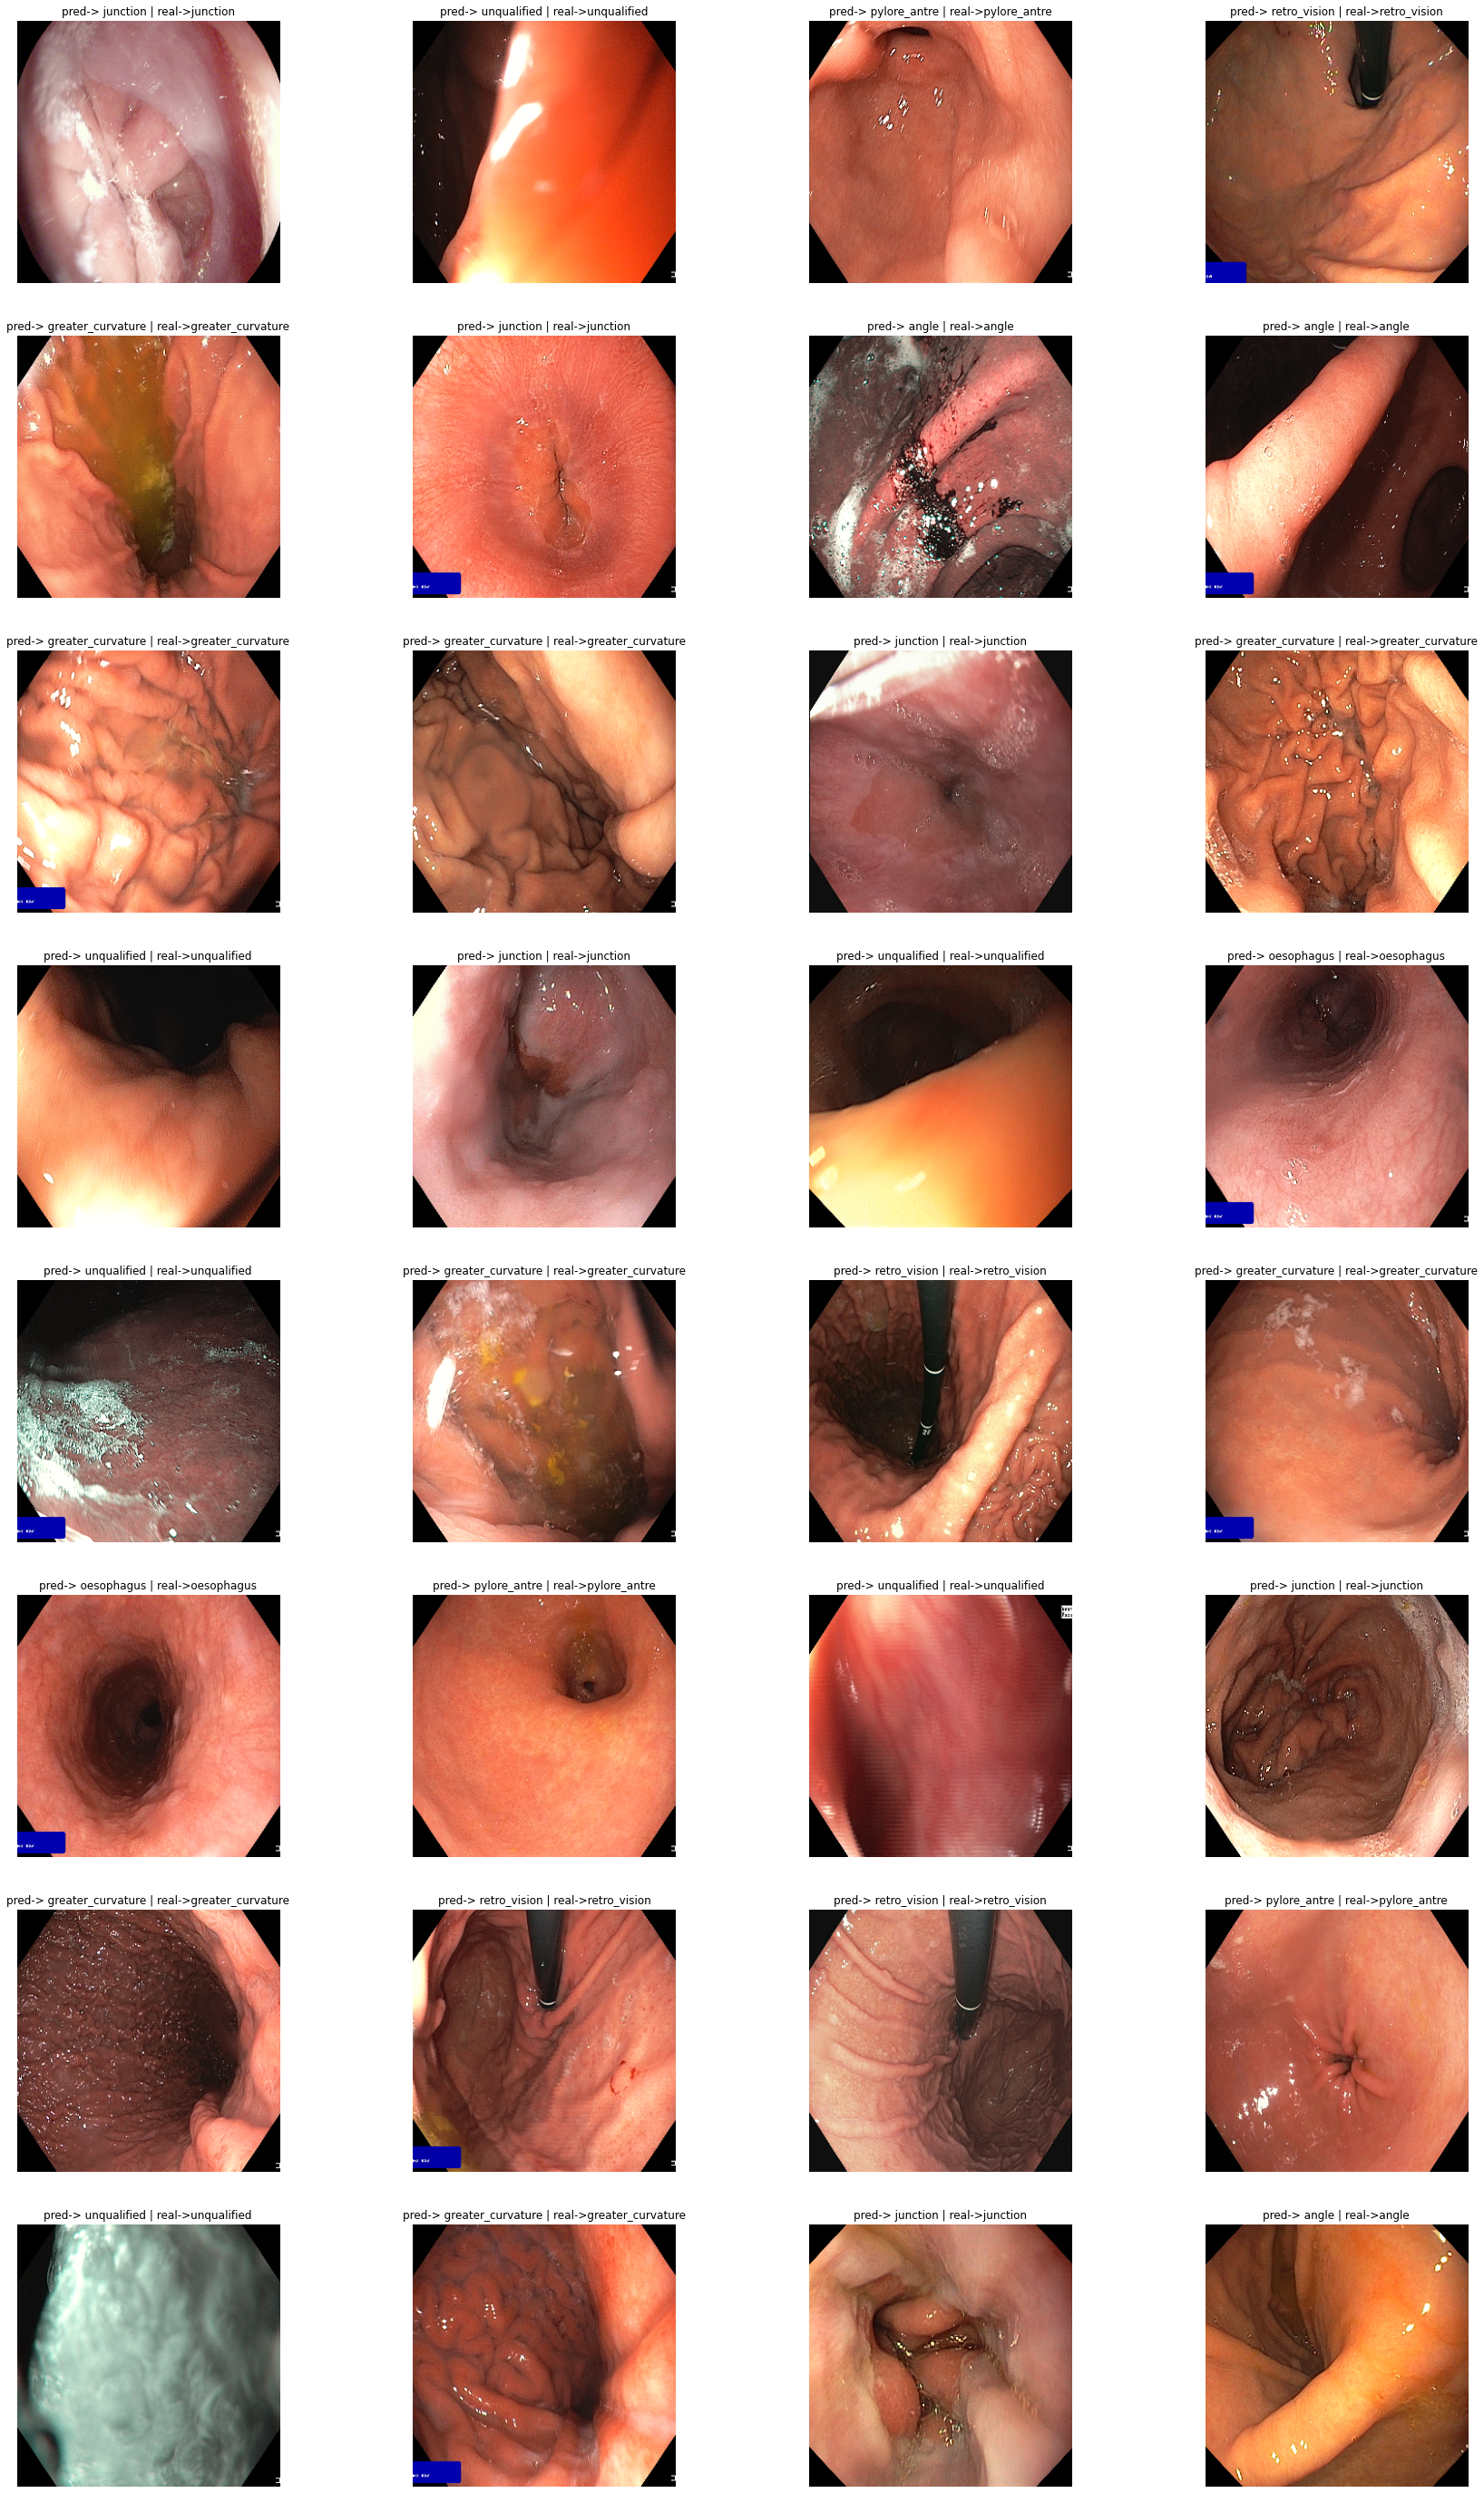

In [18]:
### EXAMPLE TRAINED MODEL ###

image_batch, label_batch = next(iter(train_ds))
pred = model.predict(image_batch)

rows, columns = 8, 4

fig = plt.figure(figsize=(30, 50))
for i in range(len(image_batch)):
    fig.add_subplot(rows,columns, i+1)
    
    source = image_batch[i].numpy()/255
    index_pred = np.argmax(pred[i])
    index_real = label_batch[i]

    plt.imshow(source)
    plt.title("pred-> " + labels[index_pred]+" | real->" + labels[index_real])
    plt.axis("off")

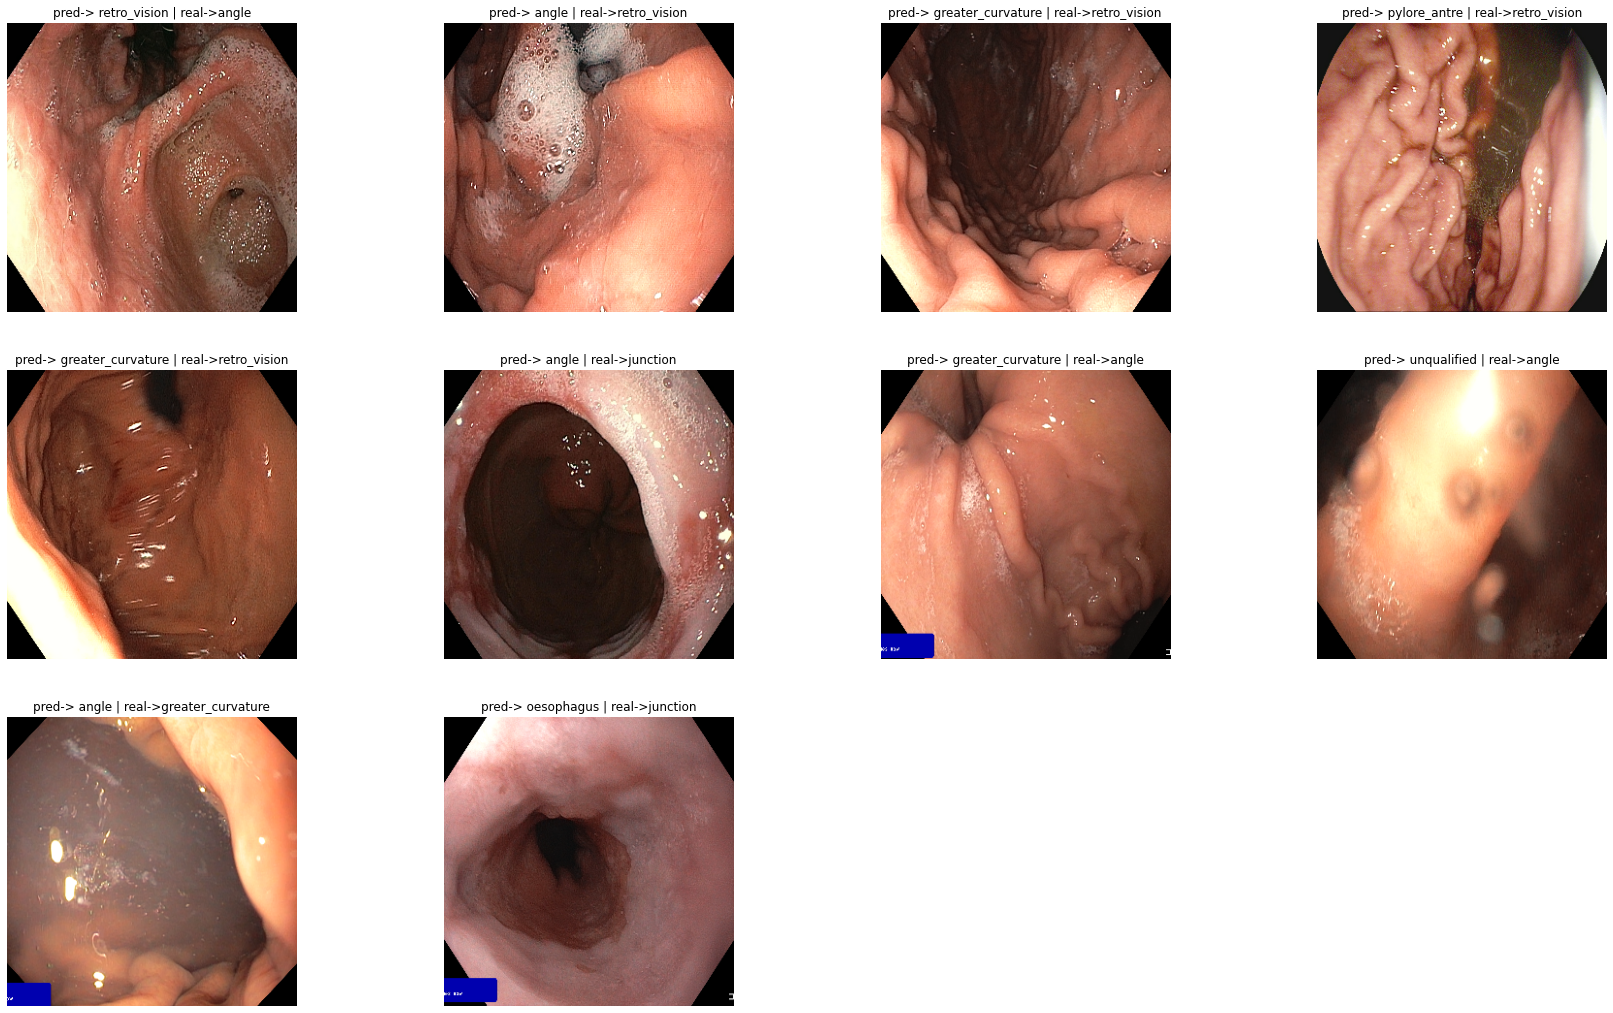

In [19]:
### model evaluation failures ###

fig = plt.figure(figsize=(30, 50))
rows, columns = 8, 4
validation_iterator = iter(val_ds)
pred_label = np.array([])
true_label = np.array([])
i = 0
j = 0
while True:
    image_batch, label_batch = validation_iterator.get_next()
    pred = model.predict(image_batch)
    index_pred = np.argmax(pred[i])
    index_real = label_batch[i]
    if len(image_batch) != batch_size : 
        break
    for k in range(len(image_batch)):
        source = image_batch[k].numpy()/255
        index_pred = np.argmax(pred[k])
        index_real = label_batch[k]
        if index_pred != index_real:
            fig.add_subplot(rows,columns,j+1)
            plt.imshow(source)
            plt.title("pred-> " + labels[index_pred]+" | real->" + labels[index_real])
            plt.axis("off")
            j+=1
    i+=1

In [20]:
# model = tf.keras.models.load_model(MODEL_PATH)

In [21]:
from PATH_G import PATH_KVASIR

kvasir_dir = pathlib.Path(PATH_KVASIR)

kvasir_ds = tf.keras.utils.image_dataset_from_directory(
    kvasir_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

model.evaluate(kvasir_ds)


Found 2764 files belonging to 7 classes.
87/87 [==============================] - 20s 217ms/step - loss: 0.0911 - accuracy: 0.9758


[0.09107301384210587, 0.975759744644165]

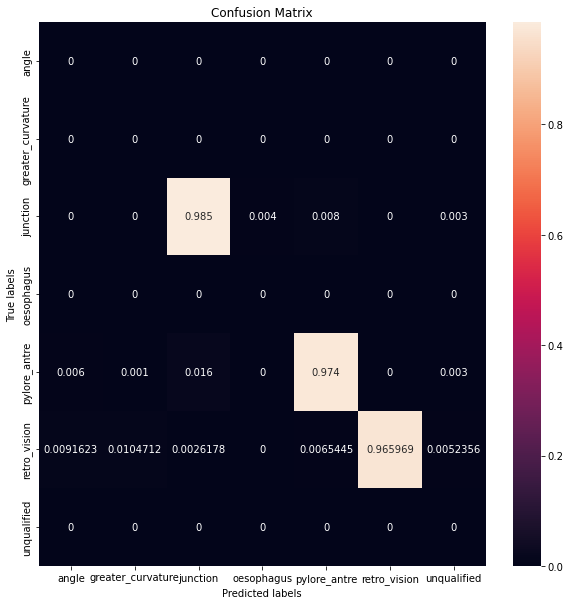

In [22]:
validation_iterator = iter(kvasir_ds)
pred_label = np.array([])
true_label = np.array([])
while True:
    image_batch, label_batch = validation_iterator.get_next()
    pred_label = np.append(pred_label,model.predict(image_batch).argmax(1))
    true_label = np.append(true_label,label_batch)
    if len(image_batch) != batch_size : 
        break
        
pred_label = np.array([labels[int(x)] for x in pred_label])
true_label = np.array([labels[int(x)] for x in true_label])

cm = confusion_matrix(true_label, pred_label, normalize='true')
fig, ax= plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);


In [ ]:
### model evaluation failures ###

fig = plt.figure(figsize=(30, 50))
rows, columns = 8, 4
validation_iterator = iter(kvasir_ds)
pred_label = np.array([])
true_label = np.array([])
i = 0
j = 0
while True:
    image_batch, label_batch = validation_iterator.get_next()
    pred = model.predict(image_batch)
    index_pred = np.argmax(pred[i])
    index_real = label_batch[i]
    if len(image_batch) != batch_size : 
        break
    for k in range(len(image_batch)):
        source = image_batch[k].numpy()/255
        index_pred = np.argmax(pred[k])
        index_real = label_batch[k]
        if index_pred != index_real:
            fig.add_subplot(rows,columns,j+1)
            plt.imshow(source)
            plt.title("pred-> " + labels[index_pred]+" | real->" + labels[index_real])
            plt.axis("off")
            j+=1
    i+=1